In [1]:
# Numpy for maths
import numpy as np
from numpy import linalg as LA
from numpy.linalg import eig

# Matplotlib for plots
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter

# Scipy to solve linear systems
from scipy.linalg import solve

# Networkx for graphs
import networkx as nx
# Pandas for dataframes
import pandas as pd

# Plotting defaults
plt.rcParams['figure.dpi'] = 1050

### Read data

In [2]:
edges = pd.read_csv('london_tube_edges.txt', sep=" ")
nodes = pd.read_csv('london_tube_nodes.txt', sep=" ")
usage = pd.read_csv('london_tube_usage.txt', sep=" ")

### Setup

In [3]:
def initialization(nodes, edges):
    '''
    Initialization and setup for analysis on the London tube
    network. 
    Inputs:
    - nodes: pd.DataFrame containing information on the nodes.
    - edges: pd.DataFrame contianing information on the edges.
    Outputs:
    - N: dimenion of the network.
    - G: Networkx graph of the network.
    - A: adjacency matrix.
    - D: degree matrix.
    - pos: dictionary of the postions of the stations.
    - num_edges: the number of edges in the network.
    '''
    
    N = len(nodes)

    # Create graph and matrix A
    G = nx.from_pandas_edgelist(edges, 'NodeID1', 'NodeID2')
    nodelist = list(nodes['index'])
    A = nx.to_numpy_array(G, nodelist=nodelist)
    # Create postion dictionary
    coor = nodes[['xcoor', 'ycoor']]
    pos = coor.to_dict(orient='index')

    for i in pos.keys():
        pos[i] = tuple(pos[i].values())
    
    # Create matrix D
    D = np.eye(N)
    for i in range(N):
        A_sq = A @ A
        D[i, i] = A_sq[i, i]

    num_edges = len(edges)
    
    return N, G, A, D, pos, num_edges

def spec_rad(A):
    '''
    Calculates the spectral radius of adjacency matrix A.
    Input:
    - A: adjacency matrix.
    Output:
    - spectral radius of matrix A.
    '''
    eigs = eig(A)[0]
    return max(abs(eigs))

def Katz(alpha, A, L=None, normed=False, approx=False):
    '''
    Calculates Katz centrality of a graph with adjacency matrix A
    and parameters t1, t2, h1 and h2 contained in the approximation
    of Katz centrality on the undirected nearest-neighbor graph 
    with shortcut.
    Inputs:
    - alpha: downweighting parameter.
    - A: adjacency matrix.
    - L: long range shortcut index, only necessary when appproximation
    parameters are requested
    - normed: boolean indicating whether the output should be normed,
    default: False.
    - approx: boolean indicating whether the approximation parameters
    for the modified ring are requested, default: False.
    Outputs:
    - centrality: Katz centrality.
    - t1 (optional): root 1.
    - t2 (optional): root 2.
    - h1 (optional): constant > 0.
    - h2 (optional): constant > 0.
    '''
    N = len(A)
    Aa = np.eye(N) - alpha*A
    rhs = np.ones(N)
    centrality = solve(Aa, rhs)
    if normed == True:
        centrality /= LA.norm(centrality, 1) 
    
    if approx==True:
     
        # Roots
        t1 = (1 - np.sqrt(1 - 4*alpha**2)) / (2*alpha)
        t2 = (1 + np.sqrt(1 - 4*alpha**2)) / (2*alpha)
    
        # solve 2x2 system to find h1 and h2
        left = np.array([[1 - 2*alpha*t1 - alpha*t1**(L-1), 1 - 2*alpha*t2 - alpha*t2**(L-1)],
                     [t1**(N/2-1) * (t1-2*alpha), t2**(N/2-1) * (t2-2*alpha)]])
        right = np.array([alpha / (1 - 2*alpha), 0])
    
        h = solve(left, right)
        h1 = float(h[0])
        h2 = float(h[1])

        return centrality, t1, t2, h1, h2
    else:
        return centrality

def NBTW_spec_rad(A, D, S):
    '''
    Calculates the spectral radius of the companion linearization
    of the reversal matrix polynomial of matrix polynomial 
    M(t) = I - At + (D-I)t^2 + (A-S)t^3. Named: C.
    Note: when dealing with an undirected network, S can be 
    replaced by A.
    Input:
    - A: adjacency matrix.
    - D: degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    Output:
    - spectral radius of matrix C.
    '''
    N = len(A)
    # Create matrix C
    C = np.zeros((3*N, 3*N))
    C[0: N, 0: N] = A
    C[0: N, N: 2*N] = np.eye(N) - D
    C[0: N, 2*N: 3*N] = S - A
    C[N: 2*N, 0: N] = np.eye(N)
    C[2*N: 3*N, N: 2*N] = np.eye(N)
    
    eigs = eig(C)[0]
    return max(abs(eigs))

def NBTW(alpha, A, D, S, L=None, normed=False, approx=False):
    '''
    Calculates NBTW centrality of a graph with adjacency matrix A
    and parameters t1, t2, h1 and h2 contained in the approximation
    of NBTW centrality on the undirected nearest-neighbor graph 
    with shortcut.
    Note: when dealing with an undirected network, S can be 
    replaced by A.
    Inputs:
    - alpha: downweighting parameter.
    - A: adjacency matrix.
    - D: diagonal degree matrix.
    - S: adjacency matrix of the subgraph obtained by removing all
    edges that are not reciprocal.
    - L: long range shortcut index, only necessary when appproximation
    parameters are requested
    - normed: boolean indicating whether the output should be normed,
    default: False.
    - approx: boolean indicating whether or not the approximation 
    parameters for the modified ring are requested, default: False.
    Outputs:
    - NBTWcentrality: NBTW centrality
    - t1 (optional): root 1.
    - t2 (optional): root 2.
    - h1 (optional): constant > 0.
    - h2 (optional): constant > 0.
    '''
    N = len(A)
    
    # deformed graph Laplacian:
    M = np.eye(N) - A*alpha + (D-np.eye(N))*alpha**2  + (A-S)*alpha**3 
    
    rhs = (1-alpha**2) * np.ones(N)
    NBTWcentrality = solve(M, rhs)
    if normed == True:
        NBTWcentrality /= LA.norm(NBTWcentrality, 1) 
    
    if approx==True:
        # Roots
        t1 = alpha
        t2 = 1 / alpha
    
        # solve 2x2 system to find h1 and h2
        left = np.array([[-alpha**2 + 1 + (alpha**2-1)*alpha**L, -1 + alpha**2 + (alpha**2-1)*alpha**(2-L)], 
                     [(alpha**2 - 1) * alpha**(N/2), -2*alpha**(2 - N/2) + (1 + alpha**2)*alpha**(-N/2)]])
        right = np.array([[alpha * (alpha+1)**2], [0]])
    
        h = solve(left, right)
        h1 = float(h[0])
        h2 = float(h[1])

        return NBTWcentrality, t1, t2, h1, h2
    else:
        return NBTWcentrality

def create_graph(A, nodesize, node_color, pos=None, circular=True, with_labels=True, arrows=True):
    '''
    Plots the graph associated with adjacency matrix A. 
    Inputs:
    - A: adjacency matrix
    - nodesize: list indicating the sizes of the nodes,
    typically the centrality vector.
    - node_color: list indicating the color for each node,
    typically the centrality vector.
    - pos: dictionary containing the positions of the 
    nodes. Only necessary when not dealing with a circular
    graph.
    - circular: boolean indicating whether or not a circular
    graph is required, default: True
    - with_labels: boolean indicating whether or not labels
    should be included with the nodes, default: True
    - arrows: boolean indicating whether the edges should 
    include arrows or not, default: True
    '''
    N = len(A)
    
    G = nx.from_numpy_matrix(A, create_using=nx.MultiDiGraph)
    labeldict = {}
    for i in range(N):
        labeldict[i] = i+1
        
    nodelist = [i for i in range(N)]
        
    if circular == True:
        nx.draw_circular(G, 
                         labels=labeldict, 
                         node_size=nodesize, 
                         node_color=node_color,
                         font_color='white',
                         nodelist=nodelist,
                         with_labels=with_labels,
                         arrows=arrows)
    else:
        nx.draw(G, 
                labels=labeldict, 
                node_size=nodesize, 
                node_color=node_color,
                font_color='white',
                pos=pos,
                nodelist=nodelist,
                with_labels=with_labels,
                arrows=arrows)   

In [4]:
N, G, A, D, pos, num_edges = initialization(nodes, edges)
perc = 0.6

### Katz

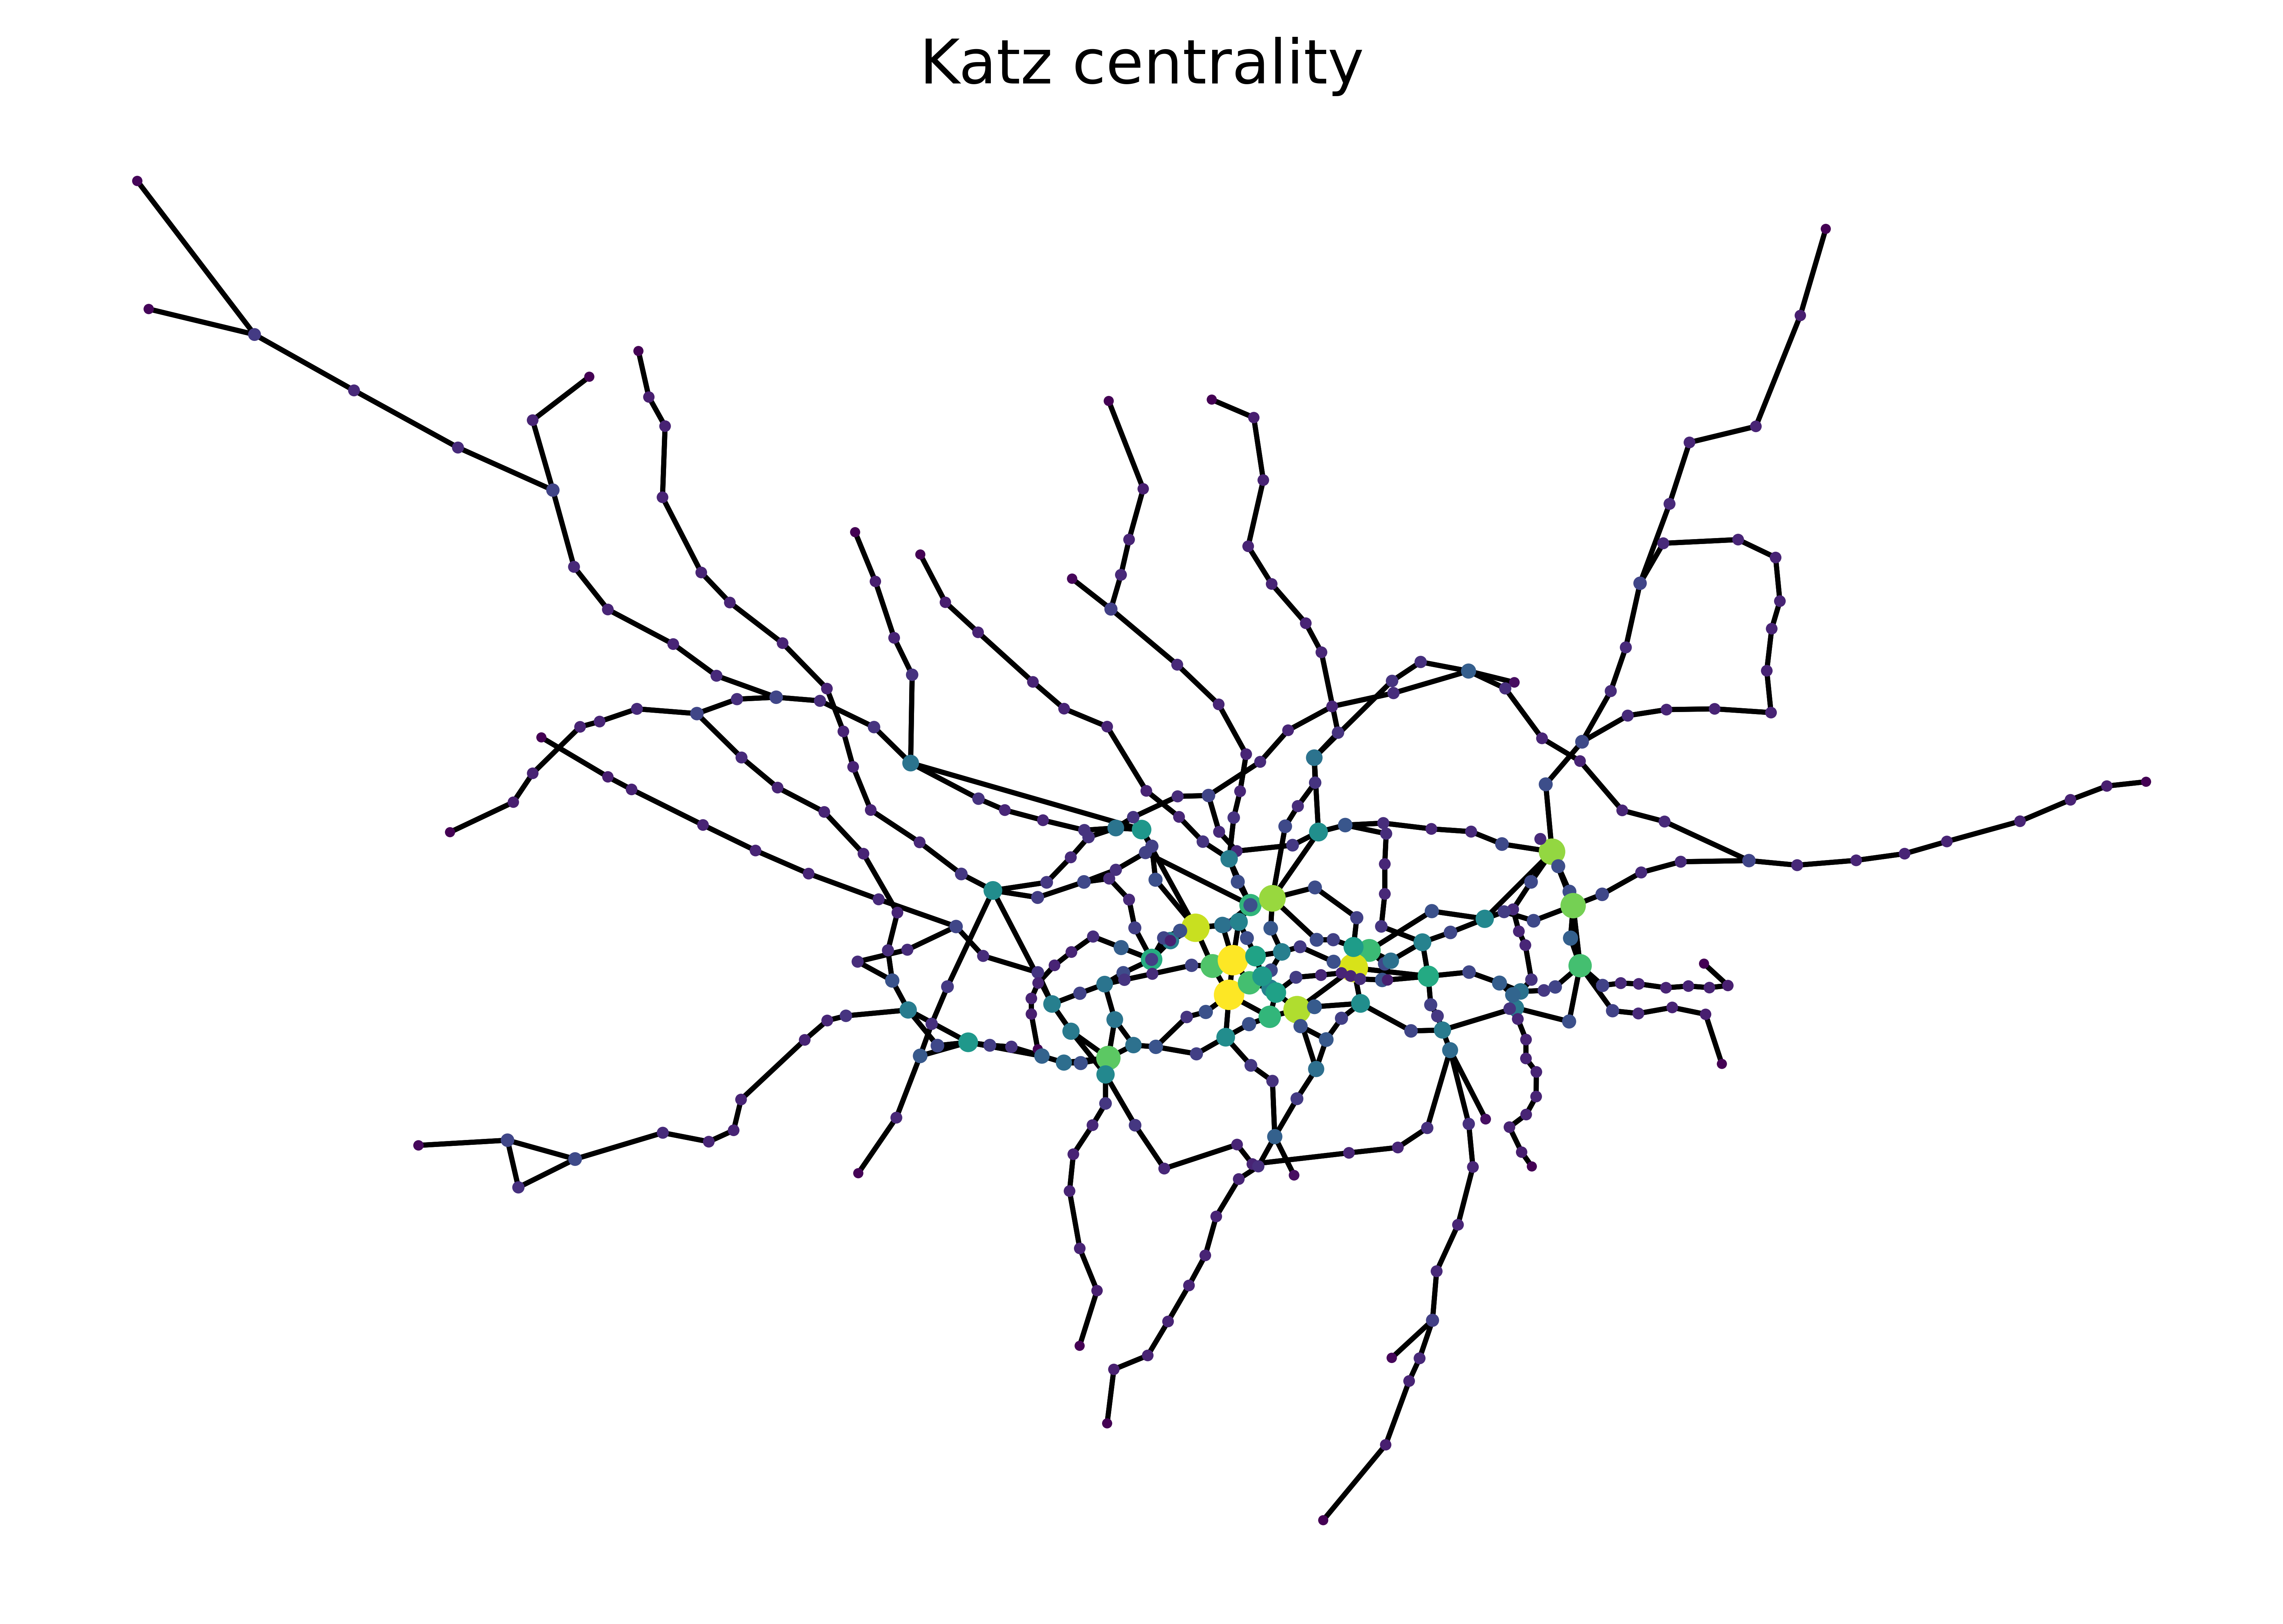

In [5]:
a = perc / spec_rad(A)
katzC = Katz(a, A, normed=True)

create_graph(A, (katzC*500)**3, katzC, pos=pos, circular=False, with_labels=False, arrows=False)
plt.title('Katz centrality')
plt.axis('off')
plt.savefig('KatzLondon.pdf', transparent=False)
plt.show()

### NBTW

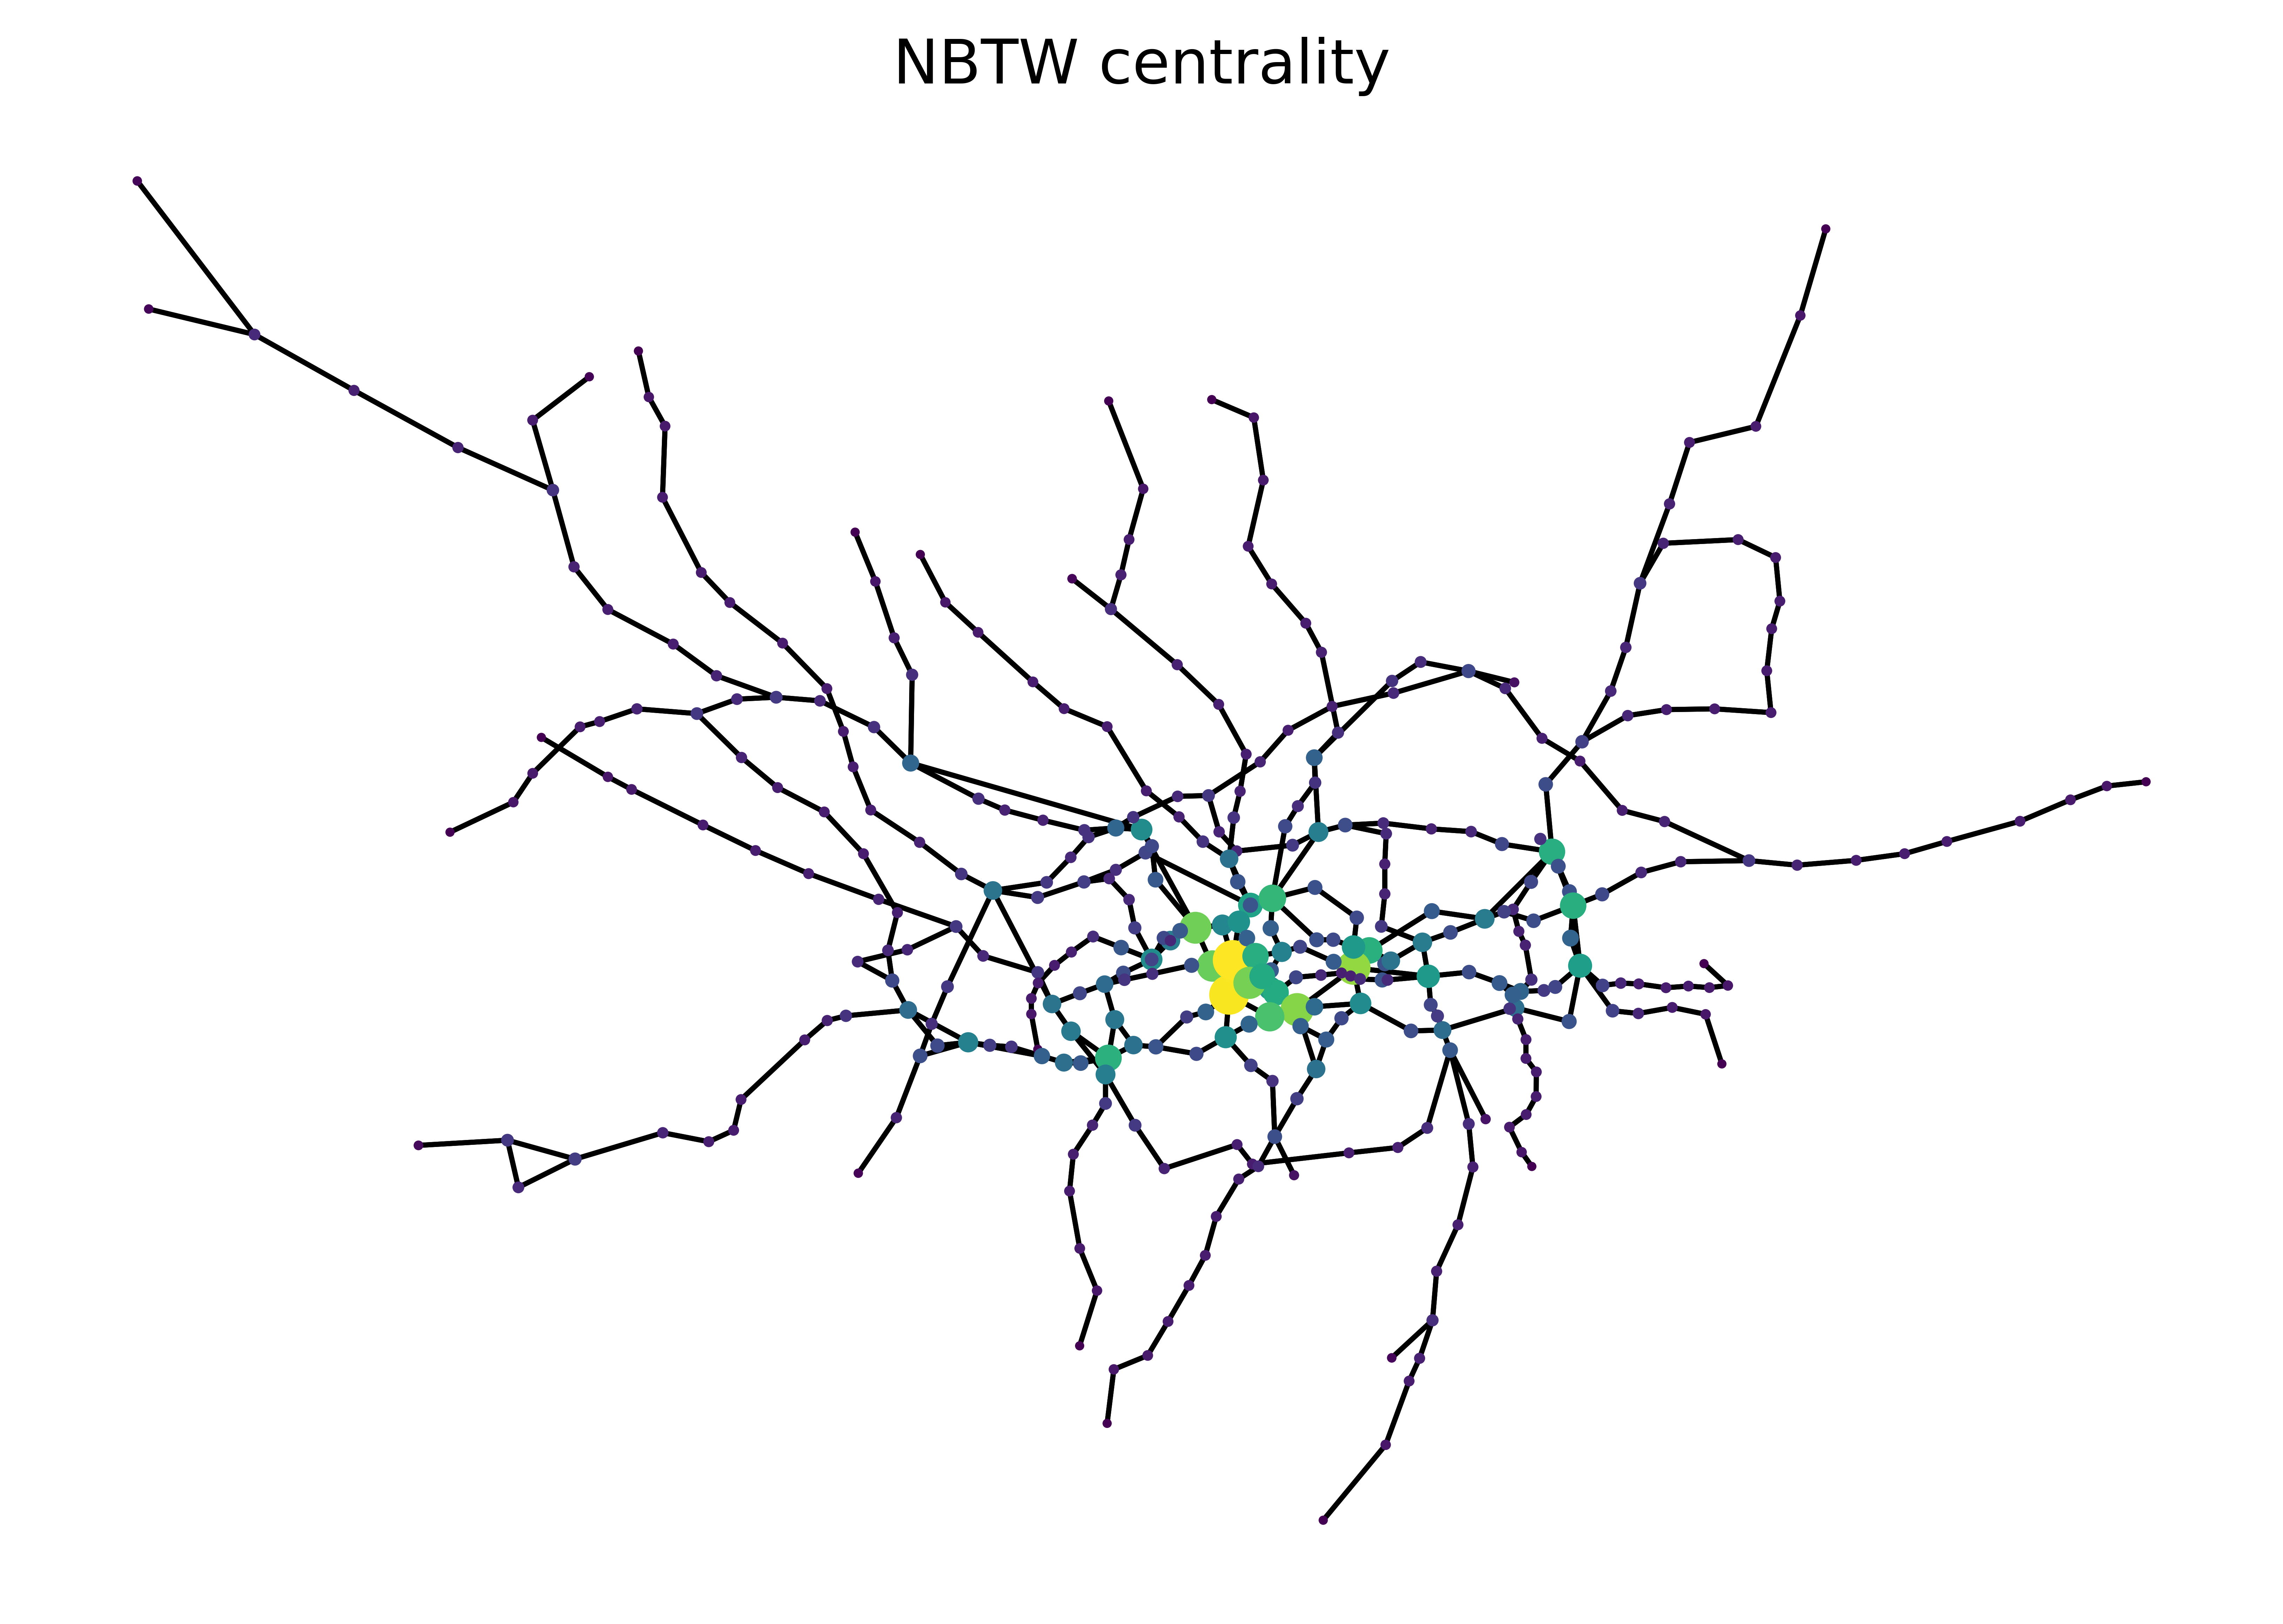

In [6]:
# network is undirected
t = perc / NBTW_spec_rad(A, D, A)

NBTWC = NBTW(t, A, D, A, normed=True)

create_graph(A, (NBTWC*500)**3, NBTWC, pos=pos, circular=False, with_labels=False, arrows=False)

plt.title('NBTW centrality')
plt.savefig('NBTWLondon.pdf', transparent=True)
plt.show()

### Plot centralities

In [7]:
usage

ID    StationName      Y2017      Y2016      Y2015      Y2014  \
0      4      actontown   6.040516   6.274649   6.235045   6.059017   
1      7        aldgate   8.846940   8.009494   7.527810   7.221566   
2      9    aldgateeast  13.998292  13.434630  12.839311  12.248009   
3     13       alperton   3.052230   3.174845   3.205455   3.171235   
4     15       amersham   2.321692   2.360700   2.287149   2.439993   
..   ...            ...        ...        ...        ...        ...   
266  368  wimbledonpark   2.184663   1.893927   1.821025   1.807402   
267  332       woodford   5.978701   5.692577   6.034086   5.870341   
268  361      woodgreen  12.889415  13.204130  13.189190  13.352231   
269  280       woodlane   3.995888   3.678778   3.698414   3.982886   
270  359   woodsidepark   3.543131   2.869951   2.816775   2.646926   

         Y2013      Y2012      Y2011      Y2010      Y2009      Y2008  
0     5.748994   5.584934   5.462387   5.428316   5.459521   5.816798  
1     6.877712   6.647283   6.235513   6.026534   5.974176   6.243135  
2    11.663144  10.134021   9.157483   8.974956   9.047885   8.152761  
3     2.956888   2.893236   2.945259   2.942987   3.044399   3.072270  
4     2.041139   2.097954   2.099560   2.109415   2.088199   2.171944  
..         ...        ...        ...        ...        ...        ...  
266   2.128289   2.108810   1.996939   2.000460   2.125523   2.084037  
267   5.585475   4.859871   4.894656   4.454295   4.477210   4.348624  
268  12.442500  11.533740  11.347719  10.934845  10.839539  10.888104  
269   3.444011   3.651658   3.437870   3.349472   3.099767   3.820056  
270   2.633565   2.660242   2.685672   2.542957   2.310474   2.308025  

[271 rows x 12 columns]

### Create 1 dataframe containing all info

In [11]:
def complete_df(G, katz, NBTW, D, usage):
    '''
    Creates one dataframe with the names of the stations and
    the centralities. It deletec the stations of which there
    is no usage data available.
    Inputs:
    - G: graph of tube network
    - katz: Katz centrality vector
    - NBTW: NBTW centrality vector
    - D: degree centrality vector
    - usage: passenger data per station 
    Output:
    - Dataframe containg all info
    '''
    N = len(D)
    nodelist = [i for i in range(N)]
    
    # Add columns
    newdf = pd.DataFrame()
    newdf['ID'] = nodelist
    newdf['Katz_centrality'] = katz
    newdf['NBTW_centrality'] = NBTW
    newdf['degree'] = D.diagonal()
    newdf['name'] = nodes['name']

    ## Remove stations without passenger data
    usage_temp = usage.copy()
    # List all stations without data
    remove_vec = [i for i in range(N) if i not in list(usage_temp['ID'])]
     
    # Drop rows with missing usage data
    for i in remove_vec:
        newdf.drop(newdf['ID'].loc[i], inplace=True)
    
    # Drop columns that would form duplicates when merging
    usage_temp.sort_values(by=['ID'], inplace=True)
    usage_temp.drop(columns = ['ID', 'StationName'], inplace=True)
    
    # Make sure the indices of the 2 dataframes match
    usage_temp.reset_index(drop=True, inplace=True)
    newdf.reset_index(drop=True, inplace=True)
    
    # Merge usage data with centrality and station name data
    frames = [newdf, usage_temp]

    return pd.concat(frames, axis=1)

In [12]:
final = complete_df(G, katzC, NBTWC, D, usage)

In [13]:
final.sort_values(by=['degree'], inplace=True, ascending=False)
final.head()

ID  Katz_centrality  NBTW_centrality  degree                 name  \
158  219         0.005191         0.005165     7.0            stratford   
21    27         0.005493         0.006033     7.0          bakerstreet   
132  181         0.005225         0.005357     7.0  kingscrossstpancras   
0      1         0.005011         0.005187     6.0              westham   
131  180         0.005351         0.006216     6.0             waterloo   

         Y2017       Y2016      Y2015      Y2014      Y2013      Y2012  \
158  61.990418   67.047270  61.442630  59.308320  54.503326  50.962909   
21   28.784591   29.754860  29.379132  32.175422  28.097997  27.744272   
132  97.918279   95.030793  93.413018  91.984534  84.866823  80.970688   
0     4.407093    3.459634   3.814553   3.508528   3.400895   3.271149   
131  91.270641  100.362256  95.138374  91.491846  89.398131  88.158546   

         Y2011      Y2010      Y2009      Y2008  
158  48.571300  29.819454  26.989730  27.231042  
21   27.017574  26.275325  25.636684  24.605375  
132  77.110350  72.576764  66.152528  67.067757  
0     3.418641   3.389493   3.123231   3.054994  
131  84.122881  81.574061  75.939796  77.202884

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9))
# fig.subplots_adjust(hspace=1) 

usagehoi = final['Y2017'] / LA.norm(final['Y2017'], 1)

ax1.scatter(final['Katz_centrality'], final['NBTW_centrality'], marker='*')
ax1.set_xlabel('Katz')
ax1.set_ylabel('NBTW')

ax2.scatter(final['Katz_centrality'], usagehoi, marker='*')
ax2.set_xlabel('Katz')
ax2.set_ylabel('2017 usage')

ax3.scatter(final['NBTW_centrality'], usagehoi, marker='*')
ax3.set_xlabel('NBTW')
ax3.set_ylabel('2017 usage')
plt.savefig('tube_scatter.pdf')
plt.show()
print(perc)

0.6


# Top 10's 

In [16]:
print('REMINDER: we\'re using', int(perc*10), '% of the spectrum')
print('corresponding to t being', t)
print('-----Katz top 10-----')
final.sort_values(by=['Katz_centrality'], inplace=True, ascending=False)
print(final.head(10)[['name', 'Katz_centrality', 'degree']])
print('-----NBTW top 10-----')
final.sort_values(by=['NBTW_centrality'], inplace=True, ascending=False)
print(final.head(10)[['name', 'NBTW_centrality', 'degree']])
print('-----2017 usage top 10-----')
final.sort_values(by=['Y2017'], inplace=True, ascending=False)
print(final.head(10)[['name', 'Y2017']])
print('-----2008 usage top 10-----')
final.sort_values(by=['Y2008'], inplace=True, ascending=False)
print(final.head(10)[['name', 'Y2008']])

REMINDER: we're using 6 % of the spectrum
corresponding to t being 0.2483336854713504
-----Katz top 10-----
                    name  Katz_centrality  degree
56          oxfordcircus         0.005811     6.0
55             greenpark         0.005808     6.0
28                  bank         0.005584     6.0
21           bakerstreet         0.005493     7.0
131             waterloo         0.005351     6.0
132  kingscrossstpancras         0.005225     7.0
158            stratford         0.005191     7.0
0                westham         0.005011     6.0
38            earlscourt         0.004843     6.0
22            bondstreet         0.004756     4.0
-----NBTW top 10-----
                    name  NBTW_centrality  degree
56          oxfordcircus         0.007217     6.0
55             greenpark         0.007153     6.0
28                  bank         0.006330     6.0
131             waterloo         0.006216     6.0
155     piccadillycircus         0.006076     4.0
21           bakerst

### Plotting the change in popular stations as $\alpha$ changes

In [27]:
df = pd.DataFrame()
nodelist = [i for i in range(N)]
df['ID'] = nodelist
df['name'] = nodes['name']

bound = 1/NBTW_spec_rad(A, D, A)
amount = 10
arange = np.linspace(0.01, bound-0.01, amount)
for a in arange:
    x = NBTW(a, A, D, A, normed=True)
    df[str('alpha {}'.format(np.round(a, 2)))] = x

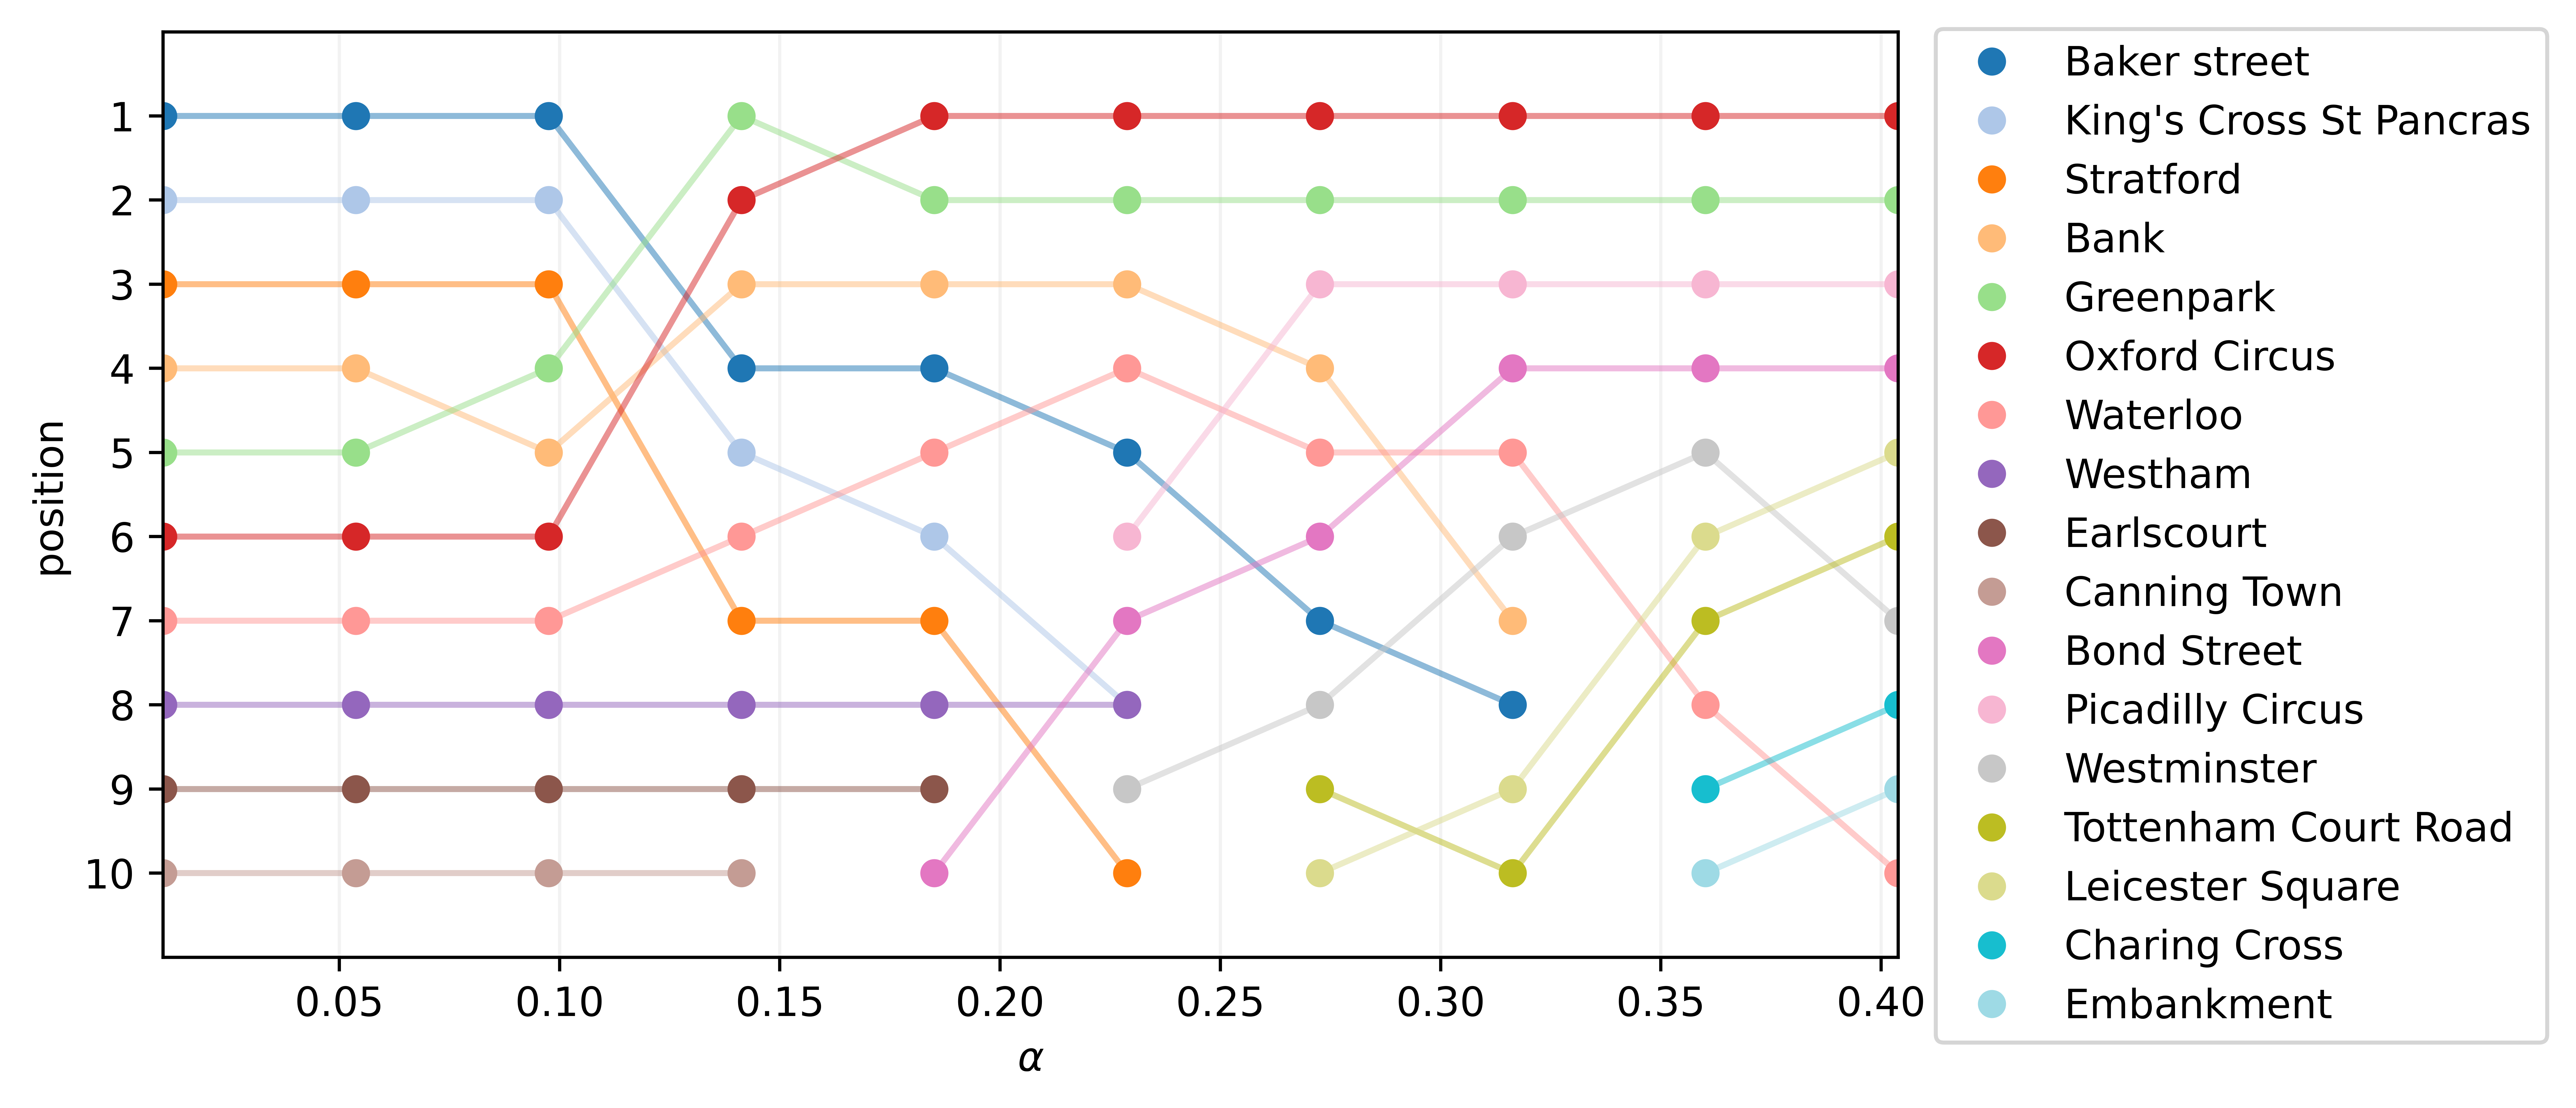

In [18]:
fig = plt.figure(figsize=(10, 4))
ax  = fig.add_subplot(111)
ax.set_position([0.1,  0.1, 0.6, 0.8])
colors = cm.tab20(np.linspace(0, 1, 17))

bakerstreet = [1, 1, 1, 4 ,4, 5 ,7 ,8 ,None ,None]
plt.plot(arange, bakerstreet, color=colors[0], alpha=0.5)
plt.plot(arange, bakerstreet, 'C0o', label ='Baker street', color=colors[0])

stpancras = [2, 2, 2, 5, 6, 8, None, None, None, None]
plt.plot(arange, stpancras, color=colors[1], alpha=0.5)
plt.plot(arange, stpancras, 'C0o', label='King\'s Cross St Pancras', color=colors[1])

stratford = [3, 3, 3, 7, 7, 10, None, None, None, None]
plt.plot(arange, stratford, color=colors[2], alpha=0.5)
plt.plot(arange, stratford, 'C0o', label='Stratford', color=colors[2])

bank = [4, 4, 5, 3, 3, 3, 4, 7, None, None]
plt.plot(arange, bank, color=colors[3], alpha=0.5)
plt.plot(arange, bank, 'C0o', label='Bank', color=colors[3])

greenpark = [5, 5, 4, 1, 2, 2, 2, 2, 2, 2]
plt.plot(arange, greenpark, color=colors[4], alpha=0.5)
plt.plot(arange, greenpark, 'C0o', label='Greenpark', color=colors[4])

oxfordcircus = [6, 6, 6, 2, 1, 1, 1, 1, 1, 1]
plt.plot(arange, oxfordcircus, color=colors[5], alpha=0.5)
plt.plot(arange, oxfordcircus, 'C0o', label='Oxford Circus', color=colors[5])

waterloo = [7, 7, 7, 6, 5, 4, 5, 5, 8, 10]
plt.plot(arange, waterloo, color=colors[6], alpha=0.5)
plt.plot(arange, waterloo, 'C0o', label='Waterloo', color=colors[6])

westham = [8, 8, 8, 8, 8, 8, None, None ,None, None]
plt.plot(arange, westham, color=colors[7], alpha=0.5)
plt.plot(arange, westham, 'C0o', label='Westham', color=colors[7])

earlscourt = [9, 9, 9, 9, 9, None, None, None, None, None]
plt.plot(arange, earlscourt, color=colors[8], alpha=0.5)
plt.plot(arange, earlscourt, 'C0o', label='Earlscourt', color=colors[8])

canningtown = [10, 10, 10, 10, None, None, None, None, None, None]
plt.plot(arange, canningtown, color=colors[9], alpha=0.5)
plt.plot(arange, canningtown, 'C0o', label='Canning Town', color=colors[9])

bondstreet = [None, None, None, None, 10, 7, 6, 4, 4, 4]
plt.plot(arange, bondstreet, color=colors[10], alpha=0.5)
plt.plot(arange, bondstreet, 'C0o', label='Bond Street', color=colors[10])

picadillycircus = [None, None, None, None, None, 6, 3, 3, 3, 3]
plt.plot(arange, picadillycircus, color=colors[11], alpha=0.5)
plt.plot(arange, picadillycircus, 'C0o', label='Picadilly Circus', color=colors[11])

westminster = [None, None, None, None, None, 9, 8, 6, 5, 7]
plt.plot(arange, westminster, color=colors[12], alpha=0.5)
plt.plot(arange, westminster, 'C0o', label='Westminster', color=colors[12])

tottenham = [None, None, None, None, None, None, 9, 10, 7, 6]
plt.plot(arange, tottenham, color=colors[13], alpha=0.5)
plt.plot(arange, tottenham, 'C0o', label='Tottenham Court Road', color=colors[13])

leicester = [None, None, None, None, None, None, 10, 9, 6, 5]
plt.plot(arange, leicester, color=colors[14], alpha=0.5)
plt.plot(arange, leicester, 'C0o',label='Leicester Square', color=colors[14])

charingcross = [None, None, None, None, None, None, None, None, 9, 8]
plt.plot(arange, charingcross, color=colors[15], alpha=0.5)
plt.plot(arange, charingcross, 'C0o',label='Charing Cross', color=colors[15])

embankment = [None, None, None, None, None, None, None, None, 10, 9]
plt.plot(arange, embankment, color=colors[16], alpha=0.5)
plt.plot(arange, embankment, 'C0o',label='Embankment', color=colors[16])


plt.legend(loc=0, bbox_to_anchor=(1.01, 1.025))
plt.xlim(0.01, bound-0.01)
plt.xlabel(r'$\alpha$')

plt.ylim(11, 0)
plt.yticks(np.arange(1, 11, step=1))  # Set label locations.
plt.ylabel('position')

plt.grid(axis='x', color='0.95')

fig.savefig('top10-2.pdf')
plt.show()

### (Pearson) Correlation

In [19]:
p = 0.9
print('We take', p, 'of the spectral radius')
t = p / NBTW_spec_rad(A, D, N)
a = p / spec_rad(A)

NBTWCen = NBTW(t, A, D, A)
katzCen = Katz(a, A)
    
final = complete_df(G, katzCen, NBTWCen, D, usage)

print('-----NBTW-----')
r = np.corrcoef(final['Y2017'], final['NBTW_centrality'])
print(r)
print('---Katz-----')
r2 = np.corrcoef(final['Y2017'], final['Katz_centrality'])
print(r2)
print('---Degree-----')
r3 = np.corrcoef(final['Y2017'], final['degree'])
print(r3)

We take 0.9 of the spectral radius
-----NBTW-----
[[1.         0.66578261]
 [0.66578261 1.        ]]
---Katz-----
[[1.         0.70462205]
 [0.70462205 1.        ]]
---Degree-----
[[1.         0.65978633]
 [0.65978633 1.        ]]


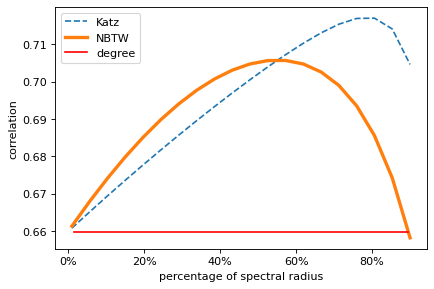

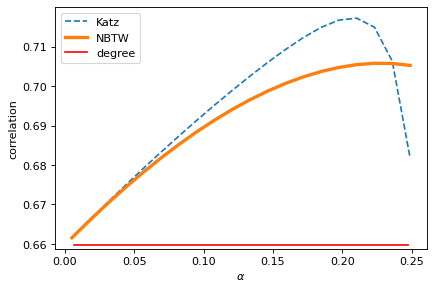

In [20]:
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 80

# Plot correlation
K_corr = []
N_corr = []
for perc in np.linspace(0.01, 0.9, 20):
    t = perc / NBTW_spec_rad(A, D, A)
    a = perc / spec_rad(A)
    
    NBTWCen = NBTW(t, A, D, A)
    katzCen = Katz(a, A)
    
    final = complete_df(G, katzCen, NBTWCen, D, usage)
    corr1 = np.corrcoef(final['Y2017'], final['NBTW_centrality'])
    N_corr.append(corr1[0,1])
    
    
    corr2 = np.corrcoef(final['Y2017'], final['Katz_centrality'])
    K_corr.append(corr2[0,1])
    
corrd = np.corrcoef(final['Y2017'], final['degree'])

fig, ax = plt.subplots()
plt.plot(np.linspace(1, 90, 20), K_corr, '--', label='Katz')
plt.plot(np.linspace(1, 90, 20), N_corr, label='NBTW', linewidth=3)
plt.axhline(y=corrd[0, 1], xmin=0.05, xmax=0.95, label='degree', c='r')
# plt.title('Correlation with the London tube usage of 2017')
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('percentage of spectral radius')
plt.ylabel('correlation')
plt.legend()
plt.savefig('LondonCorrelation.pdf')
plt.show() 


# Plot correlation
K_corr = []
N_corr = []
for a in np.linspace(0.005, 1/spec_rad(A)-0.015, 20):
    
    NBTWCen = NBTW(a, A, D, A)
    katzCen = Katz(a, A)
    
    final = complete_df(G, katzCen, NBTWCen, D, usage)
    corr1 = np.corrcoef(final['Y2017'], final['NBTW_centrality'])
    N_corr.append(corr1[0,1])
    
    
    corr2 = np.corrcoef(final['Y2017'], final['Katz_centrality'])
    K_corr.append(corr2[0,1])
    
corrd = np.corrcoef(final['Y2017'], final['degree'])

fig, ax = plt.subplots()
plt.plot(np.linspace(0.005, 1/spec_rad(A)-0.015, 20), K_corr, '--', label='Katz')
plt.plot(np.linspace(0.005, 1/spec_rad(A)-0.015, 20), N_corr, label='NBTW', linewidth=3)
plt.axhline(y=corrd[0, 1], xmin=0.05, xmax=0.95, label='degree', c='r')
plt.xlabel(r'$\alpha$')
plt.ylabel('correlation')
plt.legend()
plt.savefig('LondonCorrelation2.pdf')
plt.show()  

### Localization

In [21]:
p = 0.4
print('We take', p, 'of the spectral radius')
t = p / NBTW_spec_rad(A, D, N)
NBTWCen = NBTW(t, A, D, A)
NBTWCen /= LA.norm(NBTWCen)
NBTW_loc = sum([i**4 for i in NBTWCen])

print('localisation NBTW:', NBTW_loc)
a = p / spec_rad(A)
katzCen = Katz(a, A)
katzCen /= LA.norm(katzCen)
Katz_loc = sum([i**4 for i in katzCen])

print('localisation Katz:', Katz_loc)

We take 0.4 of the spectral radius
localisation NBTW: 0.002710696361892833
localisation Katz: 0.0029517585479661894


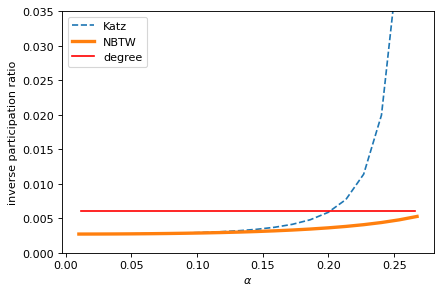

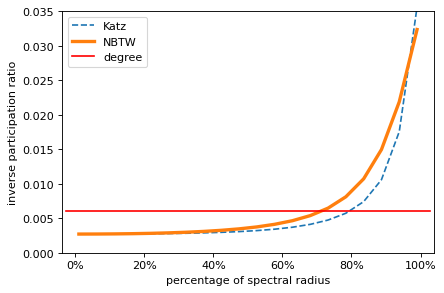

In [22]:
plt.rcParams['figure.figsize'] = (6, 4)

K_loc = []
N_loc = []
boundNBTW = 1/(NBTW_spec_rad(A, D, A)-0.01)
boundKatz = 1/(spec_rad(A)-0.05)
    
for p in np.linspace(0.01, boundKatz, 20):
    katzCen = Katz(p, A)
    katzCen /= LA.norm(katzCen)
    K_loc.append(sum(katzCen**4))
    
    NBTWCen = NBTW(p, A, D, A)
    NBTWCen /= LA.norm(NBTWCen)
    N_loc.append(sum(NBTWCen**4))

degree = list(D.diagonal())
degree /= LA.norm(degree, 2)
D_loc = sum(degree**4)
    
fig, ax = plt.subplots()
plt.plot(np.linspace(0.01, boundKatz, 20), K_loc, '--', label='Katz')
plt.plot(np.linspace(0.01, boundKatz, 20), N_loc, linewidth=3, label='NBTW')
plt.axhline(y=D_loc, xmin=0.05, xmax=0.95, label='degree', c='r')
# plt.title('Localisation London tube network')
plt.xlabel(r'$\alpha$')
plt.ylim([0, 0.035])
plt.ylabel('inverse participation ratio')
plt.legend()
plt.savefig('loc_london_fixed_a.pdf')
plt.show()  

# Plot localization
K_loc = []
N_loc = []

for p in np.linspace(0.01, 0.95, 20):
    t = p/NBTW_spec_rad(A, D, A)
    NBTWCen = NBTW(t, A, D, A)
    NBTWCen /= LA.norm(NBTWCen)
    N_loc.append(sum(NBTWCen**4))
    
    a = p/spec_rad(A)
    katzCen = Katz(a, A)
    katzCen /= LA.norm(katzCen)
    K_loc.append(sum(katzCen**4))

degree = list(D.diagonal())
degree /= LA.norm(degree)
D_loc = sum(degree**4)
    
fig, ax = plt.subplots()
plt.plot(np.linspace(1, 99, 20), K_loc, '--', label='Katz')
plt.plot(np.linspace(1, 99, 20), N_loc,linewidth=3, label='NBTW')
plt.axhline(y=D_loc, xmin=0.01, xmax=0.99, label='degree', c='r')
# plt.title('Localisation London tube network')
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.xlabel('percentage of spectral radius')
plt.ylabel('inverse participation ratio')
plt.ylim([0, 0.035])
plt.legend()
plt.savefig('loc_london_perc_a.pdf')
plt.show()  

In [23]:
print('spectral radius of Katz:', 1/spec_rad(A))
print('spectral radius of NBTW:', 1/NBTW_spec_rad(A, D, A))

spectral radius of Katz: 0.2639067687894858
spectral radius of NBTW: 0.413889475785584
